In [1]:
# Define imports
import scipy as spy
import numpy as np
import sympy as sp
from matplotlib import pyplot as plt
import spectrally_regularised_LVMs as srLVMs

# Implement a simple FFT function

In [2]:
# Simple FFT function
def fft_vis(x, Fs):
    n = len(x)

    # Cut in half at Nyquist frequency
    fft_freq = np.fft.fftfreq(n, 1/Fs)[:n//2]
    fft_val = 2/n * np.abs(np.fft.fft(x))[:n//2]
    
    return fft_freq, fft_val

# Define the properties of the two parameter vectors

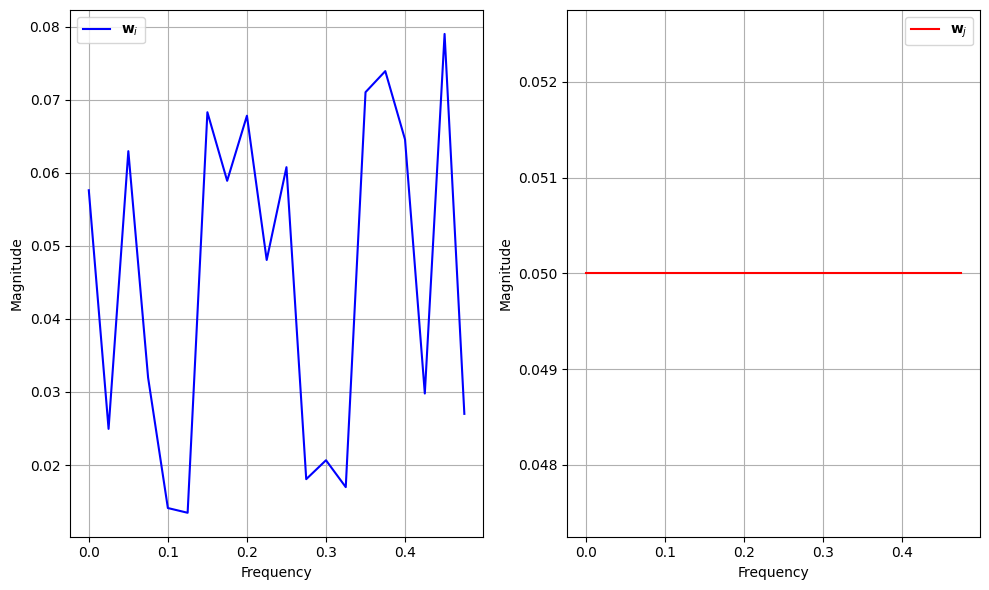

In [3]:
Ddim = 40 # Dimensionality of the problem
Fs = 1.0 # The sampling frequency
alpha_reg = 1.0 # Set to one for this example

w_i = np.random.randn(Ddim, 1)  # Random vector
w_i /= np.linalg.norm(w_i) # Normalised (not strictly necessary here)

w_j = np.zeros((Ddim, 1)) # Broadband vector (excites all frequencies equally)
w_j[0, 0] = 1 

fig, ax = plt.subplots(1, 2, figsize = (10, 6))
ax[0].plot(*fft_vis(w_i[:, 0], Fs), color = "b", label = r"$\mathbf{w}_i$")
ax[1].plot(*fft_vis(w_j[:, 0], Fs), color = "r", label = r"$\mathbf{w}_j$")

for axs in ax:
    axs.grid()
    axs.set_xlabel("Frequency")
    axs.set_ylabel("Magnitude")
    axs.grid(visible = True)
    axs.legend()

fig.tight_layout()

plt.show()

# Paper derivation

## b vector (Represents squared spectral amplitude)
$$ \mathbf{b}(\mathbf{w}) = \frac{1}{D} \left( \mathbf{R} \mathbf{w} \odot \mathbf{R} \mathbf{w} + \mathbf{I} \mathbf{w} \odot \mathbf{I} \mathbf{w}  \right) $$

In [4]:
D_matrix = spy.linalg.dft(Ddim, scale = None) # unscaled matrix

def b_vector(D, w):
    Ddim = w.shape[0]
    
    return 1/Ddim * np.abs(D @ w)**2 # More efficient implementation

## Compute loss

$$ \mathcal{L}_{sr}(\mathbf{w}_i) = \alpha \sum_{j=1}^{i-1} h(\mathbf{w}_{i}, \mathbf{w}_{j}),$$
where 
$$h(\mathbf{w}_{i}, \mathbf{w}_{j}) = \mathbf{b}(\mathbf{w}_i)^T \mathbf{b}(\mathbf{w}_j).$$
For this example, $i=2$ and $j = 1$.

In [5]:
def h_loss(D, w_i, w_j):
    
    b_wi = b_vector(D, w_i)
    b_wj = b_vector(D, w_j)
    
    return alpha_reg * (b_wi.T @ b_wj)[0, 0]

## Compute the gradient vector

$$ \nabla_{\mathbf{w}_i} \mathcal{L}_{sr}(\mathbf{w}_i) = \frac{2 \cdot \alpha}{D} \sum_{j=1}^{i - 1} \left[ \text{diag}(\mathbf{R} \mathbf{w}_i)\mathbf{R} +  \text{diag}(\mathbf{I} \mathbf{w}_i)\mathbf{I} \right]^T \mathbf{b}(\mathbf{w}_j) $$

In [6]:
def h_grad(D, w_i, w_j):
    
    Ddim = D.shape[0]
    
    Re = np.real(D)
    Im = np.imag(D)
    
    b_wj = b_vector(D, w_j) # b_wj carries a 1/D factor already.
    
    grad = ((2 * alpha_reg) / Ddim) * (np.diag((Re @ w_i)[:, 0]) @ Re + np.diag((Im @ w_i)[:, 0]) @ Im).T @  b_wj

    return grad

# Compute the Hessian matrix

$$ \mathbf{H}_{sr} =  \frac{2\cdot \alpha}{D} \sum_{j=1}^{i - 1} \begin{bmatrix} \mathbf{b}(\mathbf{w}_j)^T \left( \text{diag}\left(\mathbf{r}_{1}\right) \mathbf{R} +  \text{diag}\left(\mathbf{i}_{1}\right) \mathbf{I} \right) \\ \vdots \\ \mathbf{b}(\mathbf{w}_j)^T \left( \text{diag}\left(\mathbf{r}_{D}\right) \mathbf{R} + \text{diag}\left(\mathbf{i}_{D}\right) \mathbf{I} \right)\end{bmatrix}.  $$

In [7]:
def h_hess(D, w_i, w_j):
    
    Ddim = D.shape[0]
    
    hess = np.zeros((Ddim, Ddim))
    
    Re = np.real(D)
    Im = np.imag(D)
    
    b_wj = b_vector(D, w_j) # b_wj carries a 1/D factor already.
    
    for i in range(Ddim):
        r_i = Re[:, [i]]
        i_i = Im[:, [i]]
        
        hess_row = b_wj.T @ (np.diag(r_i[:, 0]) @ Re + np.diag(i_i[:, 0]) @ Im)
        
        hess[i, :] = hess_row
        
    return ((2 * alpha_reg) / Ddim) *  np.array(hess)

# Sympy derivation

In [8]:
string_w_sp = [f"w_{i}" for i in range(Ddim)] # Create a list w variable strings

symbols = sp.symbols(",".join(string_w_sp)) # Create the SymPy symbols
vals = [(s_i, w_i_val) for s_i, w_i_val in zip(symbols, w_i[:, 0])] # Create the substitution values

w_i_sp = sp.Matrix(symbols) # Symbolic w_i vector
w_j_sp = sp.Matrix(w_j[:, 0]) # w_j vector

# Split into real and imaginary DFT matrix components for sympy version
Re_sp = sp.Matrix(np.real(D_matrix)) 
Im_sp = sp.Matrix(np.imag(D_matrix))

# Check sizes to ensure that everything is fine
print(w_i_sp.shape)
print(w_j_sp.shape)
print(Re_sp.shape)
print(Im_sp.shape)

# Check that w_i_sp is a column vector of variables
display(w_i_sp.T)

(40, 1)
(40, 1)
(40, 40)
(40, 40)


Matrix([[w_0, w_1, w_2, w_3, w_4, w_5, w_6, w_7, w_8, w_9, w_10, w_11, w_12, w_13, w_14, w_15, w_16, w_17, w_18, w_19, w_20, w_21, w_22, w_23, w_24, w_25, w_26, w_27, w_28, w_29, w_30, w_31, w_32, w_33, w_34, w_35, w_36, w_37, w_38, w_39]])

In [9]:
# Note, running this cell takes a while because of the .applyfunc(). 
# Decreasing Ddim reduces the solution time.

def b_vector_sp(Re, Im, w): # Define the b_vector using sympy methods

    Ddim = w.shape[0]
    
    Rw = Re @ w
    Iw = Im @ w
    
    return 1/Ddim * (Rw.applyfunc(lambda x: x**2) + Iw.applyfunc(lambda x: x**2)) # easiest way to compute Hadamard product

def loss_sp_func(Re, Im, w_i, w_j): # Define the loss
    
    Xw_i = b_vector_sp(Re, Im, w_i)
    Xw_j = b_vector_sp(Re, Im, w_j)
    
    return Xw_i.T @ Xw_j

loss_sp = loss_sp_func(Re_sp, Im_sp, w_i_sp, w_j_sp)[0, 0]
grad_sp = sp.derive_by_array(loss_sp, symbols)
hess_sp = sp.derive_by_array(grad_sp, symbols)

# Visualise comparison

In this comparison, we check the implementations of the b_vector for the implementation in this notebook and the implementation given in the *spectrally-regularised-LVMs* package against the SymPy implementation.

## Initialise the spectral objective from the Package

In [10]:
# Initialise spectral objective
spectral_reg = srLVMs.SpectralObjective(Ddim, 
                                        save_hessian_flag = True, 
                                        inv_hessian_flag = False)

# Get the Real and Imaginary components of the DFT matrix
Re_code, Im_code = spectral_reg.decompose_DFT()

## Check $\mathbf{b}(\mathbf{w}_i)$:

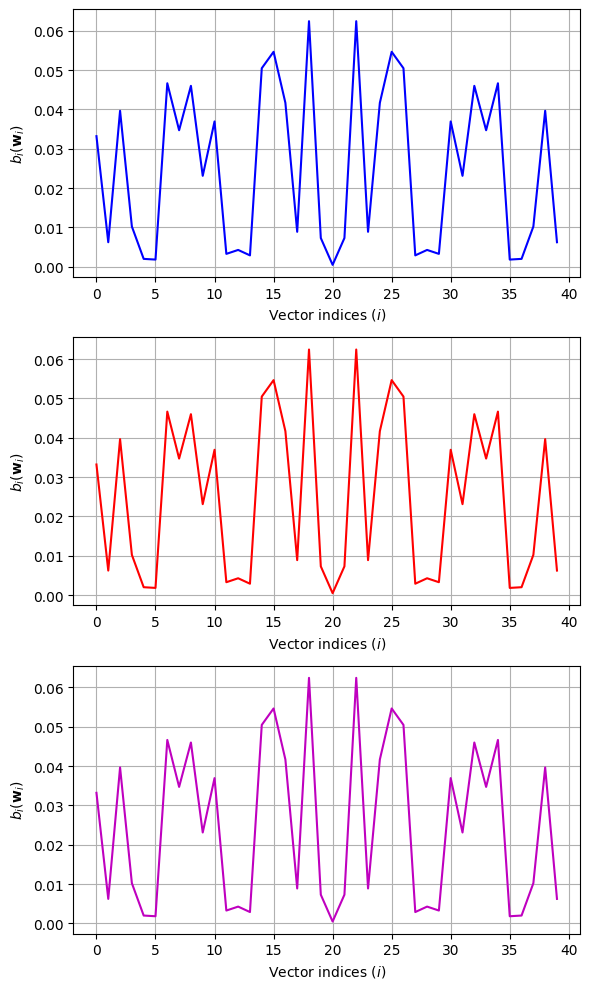

Vector norm (notebook implementation): 7.71446226210426e-17
Vector norm (package implementation): 7.424940717479475e-17


In [11]:
# Get the b vector using the notebook implementation
b_local = b_vector(D_matrix, w_i)[:, 0]

# Get the b vector using the package implementation 
b_code = spectral_reg.Xw(Re_code, Im_code, w_i)[:, 0]

# Get the b vector using the 
b_sympy = b_vector_sp(Re_sp, Im_sp, w_i_sp).subs(vals)
b_sympy = np.array(b_sympy).astype(np.float64)[:, 0] # Convert to numpy

fig, ax = plt.subplots(3, 1, figsize = (6, 10))
ax[0].plot(b_local, color = "b", label = "Notebook implementation")
ax[1].plot(b_code, color = "r", label = "Package implementation")
ax[2].plot(b_sympy, color = "m", label = "SymPy implementation")

for axs in ax:
    axs.set_xlabel(r"Vector indices ($i$)")
    axs.set_ylabel(r"$b_i(\mathbf{w}_i)$")
    axs.grid(visible = True)

fig.tight_layout()
plt.show()

print(f"Vector norm (notebook implementation): {np.linalg.norm(b_local - b_sympy)}")
print(f"Vector norm (package implementation): {np.linalg.norm(b_code - b_sympy)}")

## Check the loss function values for the three implementations

In [12]:
loss_local = h_loss(D_matrix, w_i, w_j)
loss_code = spectral_reg.spectral_loss(w_i, w_j)
loss_sp_vals = loss_sp.subs(vals)

print(f"Notebook implementation: {loss_local}")
print(f"Package implementation: {loss_code}")
print(f"SymPy implementation: {loss_sp_vals}")

Notebook implementation: 0.025000000000000005
Package implementation: 0.025000000000000005
SymPy implementation: 0.0250000000000000


## Check the gradient vectors for the three implementations

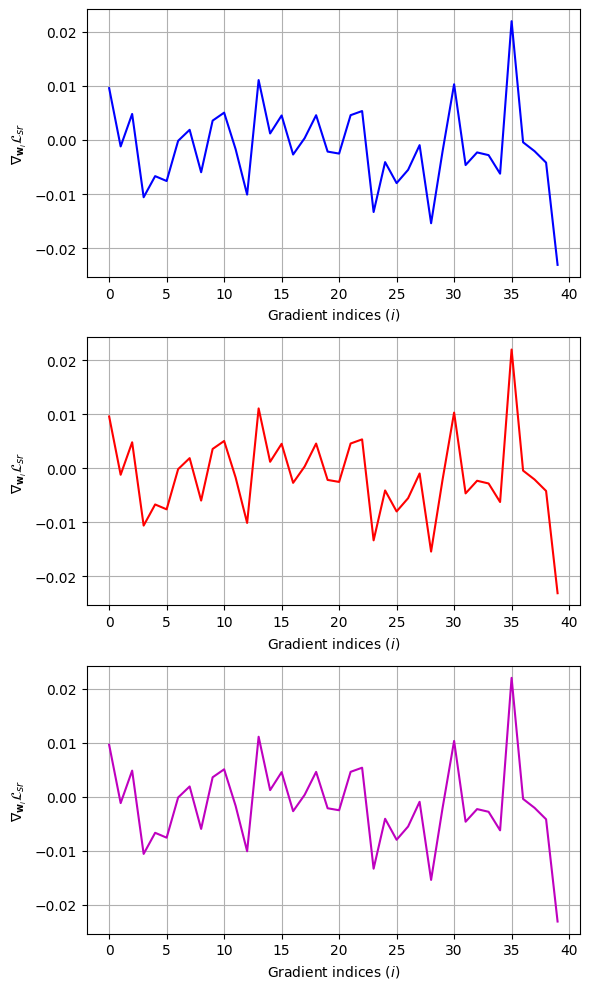

Gradient norm (notebook implementation): 1.909036895938054e-17
Gradient norm (package implementation): 1.8046939234408237e-17


In [13]:
grad_local = h_grad(D_matrix, w_i, w_j)[:, 0]
grad_code = spectral_reg.spectral_derivative(w_i, w_j)
grad_sp_vals = grad_sp.subs(vals)
grad_sp_vals = np.array(grad_sp_vals).astype(np.float64)

fig, ax = plt.subplots(3, 1, figsize = (6, 10))
ax[0].plot(grad_local, color = "b", label = "Notebook implementation")
ax[1].plot(grad_code, color = "r", label = "Package implementation")
ax[2].plot(grad_sp_vals, color = "m", label = "SymPy implementation")

for axs in ax:
    axs.set_xlabel(r"Gradient indices ($i$)")
    axs.set_ylabel(r"$\nabla_{\mathbf{w}_i} \mathcal{L}_{sr}$")
    axs.grid(visible = True)

fig.tight_layout()
plt.show()

print(f"Gradient norm (notebook implementation): {np.linalg.norm(grad_local - grad_sp_vals)}")
print(f"Gradient norm (package implementation): {np.linalg.norm(grad_code - grad_sp_vals)}")

## Check the Hessian matrices for the three implementations

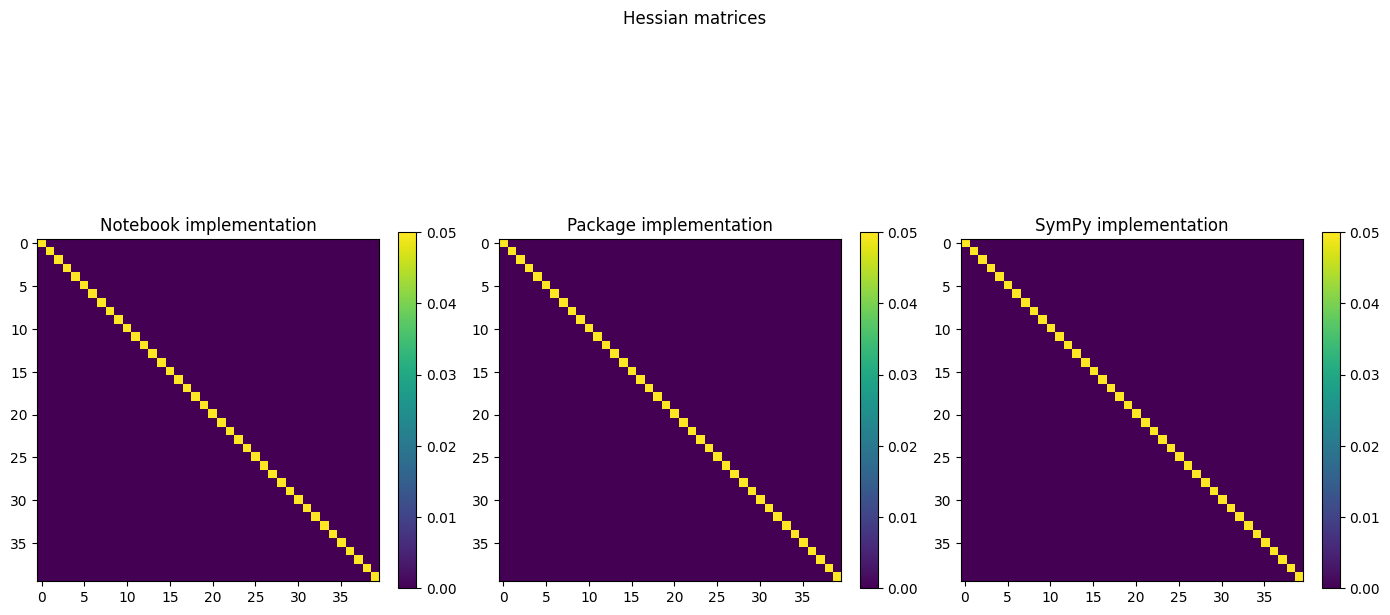

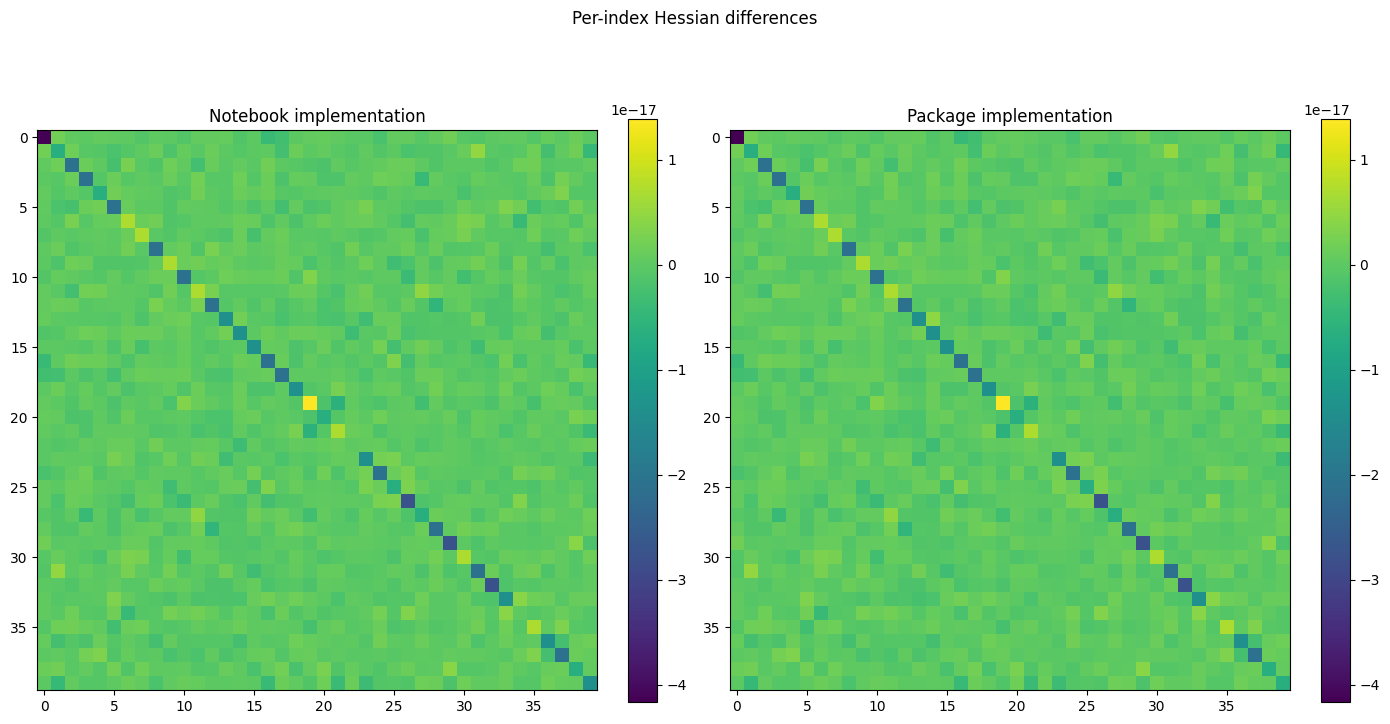

Hessian matrix norm (notebook implementation): 1.1862556831451385e-16
Hessian matrix norm (package implementation): 1.180793940172975e-16


In [14]:
hess_local = h_hess(D_matrix, w_i, w_j)
hess_code = spectral_reg.spectral_hessian(w_i, w_j)
hess_sp_vals = hess_sp.subs(vals)
hess_sp_vals = np.array(hess_sp_vals).astype(np.float64)

fig, ax = plt.subplots(1, 3, figsize = (14, 8))
fig.suptitle("Hessian matrices")
ax[0].set_title("Notebook implementation")
ax[1].set_title("Package implementation")
ax[2].set_title("SymPy implementation")

m1 = ax[0].imshow(hess_local)
m2 = ax[1].imshow(hess_code)
m3 = ax[2].imshow(np.array(hess_sp_vals).astype(np.float64))

for axs, ms in zip(ax, [m1, m2, m3]):
    plt.colorbar(ms, ax = axs, fraction=0.047)

fig.tight_layout()
plt.show()

fig, ax = plt.subplots(1, 2, figsize = (14, 8))
fig.suptitle("Per-index Hessian differences")
ax[0].set_title("Notebook implementation")
ax[1].set_title("Package implementation")

m1 = ax[0].imshow(hess_local - hess_sp_vals)
m2 = ax[1].imshow(hess_code - hess_sp_vals)

for axs, ms in zip(ax, [m1, m2]):
    plt.colorbar(ms, ax = axs, fraction=0.047)
fig.tight_layout()
plt.show()

print(f"Hessian matrix norm (notebook implementation): {np.linalg.norm(hess_local - hess_sp_vals)}")
print(f"Hessian matrix norm (package implementation): {np.linalg.norm(hess_code - hess_sp_vals)}")

# Final example: Newton's method using the notebook implementation

In this example, we will look at what happens to the $\mathbf{w}_i$ vector if it is enforced to be orthogonal to the $\mathbf{w}_j$ vector. As the $\mathbf{w}_j$ vector is active everywhere, it is expected that performing Newton iteration will reduce the vector to zero vector. 

Note that as the Hessian matrix is no longer a function of our parameter vector $\mathbf{w}_i$, it is expected that we get to the solution in 1 iteration.

This is an extreme example, as it is not expected that the $\mathbf{w}_j$ excite all frequencies equally, but it ensures that some logic of the problem is correct.

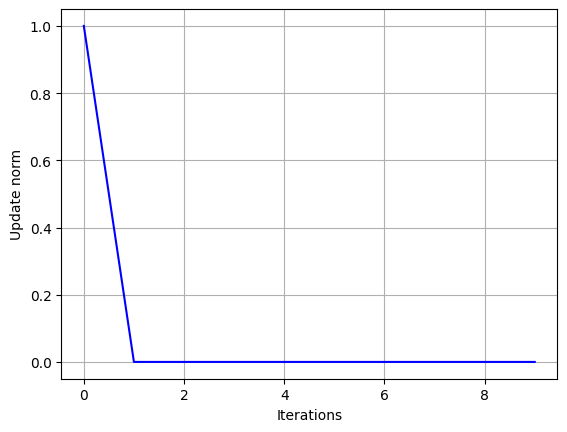

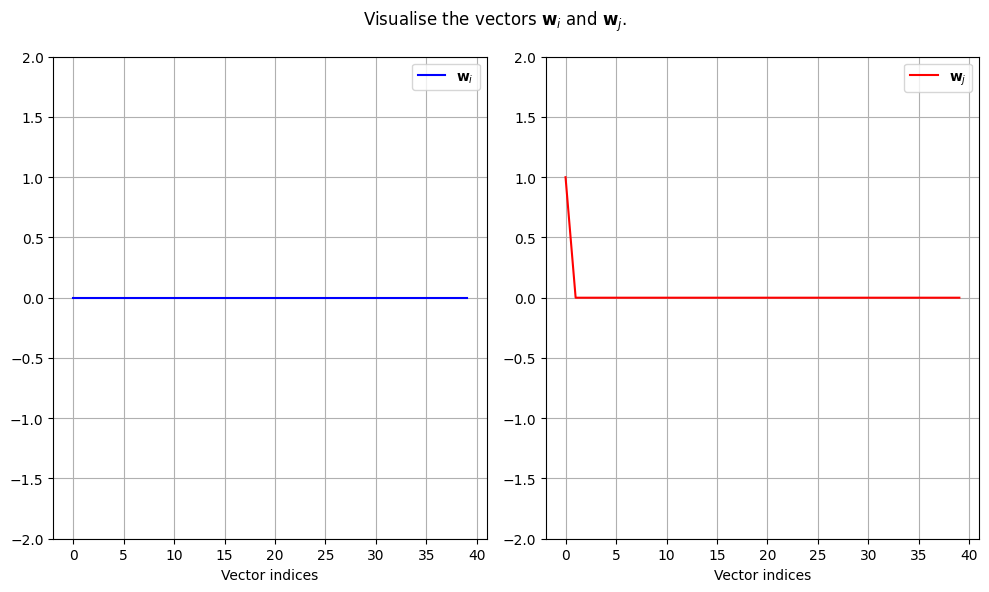

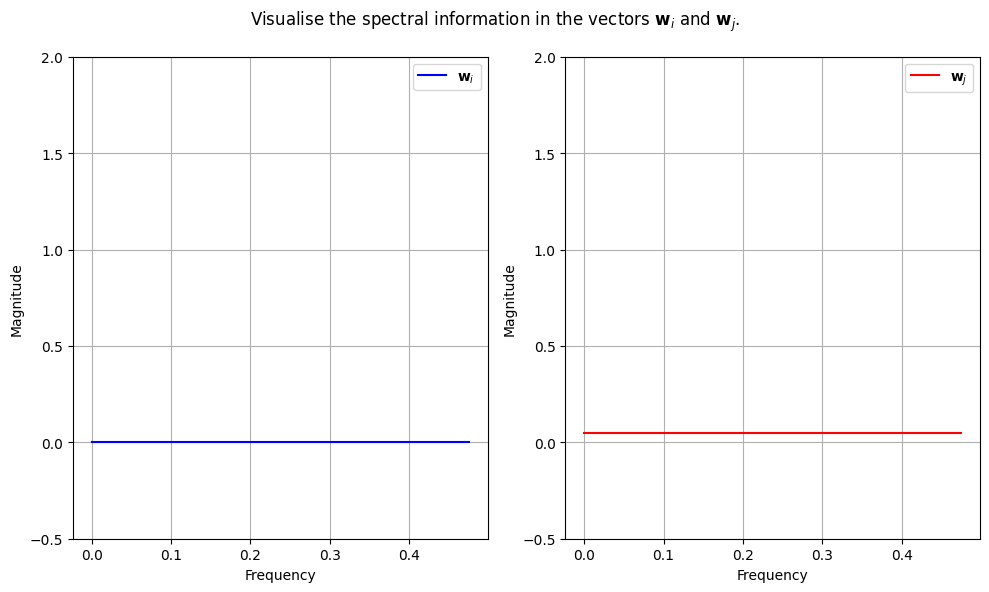

In [15]:
w_i_newton = w_i.copy()
n_iters = 10
update_norm = np.zeros(n_iters)

for i in range(10):

    grad = h_grad(D_matrix, w_i_newton, w_j)
    hess = h_hess(D_matrix, w_i_newton, w_j)

    # Compute update
    delta = np.linalg.solve(hess, grad)
    
    # Adjust w_i_newton
    w_i_newton -= delta

    # Store norm of update
    update_norm[i] = np.linalg.norm(delta)

plt.figure()
plt.plot(update_norm, color = "b")
plt.xlabel("Iterations")
plt.ylabel("Update norm")
plt.grid()
plt.show()

fig, ax = plt.subplots(1, 2, figsize = (10, 6))
fig.suptitle(r"Visualise the vectors $\mathbf{w}_i$ and $\mathbf{w}_j$.")
ax[0].plot(w_i_newton[:, 0], color = "b", label = r"$\mathbf{w}_i$")
ax[1].plot(w_j[:, 0], color = "r", label = r"$\mathbf{w}_j$")

for axs in ax:
    axs.grid()
    axs.set_xlabel("Vector indices")
    axs.grid(visible = True)
    axs.legend()
    axs.set_ylim(-2, 2)

fig.tight_layout()

plt.show()

fig, ax = plt.subplots(1, 2, figsize = (10, 6))
fig.suptitle(r"Visualise the spectral information in the vectors $\mathbf{w}_i$ and $\mathbf{w}_j$.")
ax[0].plot(*fft_vis(w_i_newton[:, 0], Fs), color = "b", label = r"$\mathbf{w}_i$")
ax[1].plot(*fft_vis(w_j[:, 0], Fs), color = "r", label = r"$\mathbf{w}_j$")

for axs in ax:
    axs.grid()
    axs.set_xlabel("Frequency")
    axs.set_ylabel("Magnitude")
    axs.grid(visible = True)
    axs.legend()
    axs.set_ylim(-0.5, 2)

fig.tight_layout()

plt.show()

In [16]:
w_i_newton.T

array([[-4.66146296e-156,  6.99219444e-156, -3.49609722e-156,
        -3.69708338e-156,  1.86458518e-155, -3.49609722e-156,
        -9.32292591e-156,  2.33073148e-156,  6.99219444e-156,
        -2.40811905e-156,  9.32292591e-156,  5.82682870e-157,
        -3.49609722e-156,  0.00000000e+000,  4.66146296e-156,
         4.66146296e-156,  0.00000000e+000,  3.49609722e-156,
         0.00000000e+000, -3.86027401e-156, -4.66146296e-156,
        -2.33073148e-156,  0.00000000e+000, -4.66146296e-156,
         2.62207291e-156,  1.74804861e-156,  4.66146296e-156,
        -2.33073148e-155,  1.06670956e-156, -2.33073148e-156,
        -3.49609722e-156,  2.33073148e-156, -5.82682870e-157,
         4.66146296e-156, -8.74024304e-157,  0.00000000e+000,
        -3.49609722e-156, -2.33073148e-156, -2.33073148e-156,
        -6.99219444e-156]])

Hence, we can see that the updated $\mathbf{w}_i$ vector is numerically zero, which is expected given that $\mathbf{w}_j$ is a broadband filter that excites all frequencies equally. 